# Getting set up

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import scipy as sp
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics.regression import r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor

## helper functions

In [3]:
def plot_xsections(X, y, **kwargs):
    figsize = kwargs.get('figsize', (15,10))
    colnames = kwargs.get('colnames', None)
    ncol = kwargs.get('ncol', 4)

    N = X.shape[1]
    nrow = np.ceil(N/ncol)

    plt.figure(figsize=figsize)

    for j in range(N):
        plt.subplot(nrow, ncol, j+1)
        plt.plot(X[:,j], y, '.')
        if colnames is not None:
            plt.xlabel(colnames[j])
            plt.ylabel(colnames[-1])
    return

In [4]:
def hist_groups(X, **kwargs):
    figsize = kwargs.get('figsize', (15,10))
    xlabs = kwargs.get('xlabs', None)
    ncol = kwargs.get('ncol', 4)

    N = X.shape[1]
    nrow = np.ceil(N/ncol)

    plt.figure(figsize=figsize)

    for j in range(N):
        plt.subplot(nrow, ncol, j+1)
        plt.hist(X[:,j])
        if xlabs is not None:
            plt.xlabel(xlabs[j])
    return

In [5]:
def score_result(y_true, y_pred):
    scorenames = ['mean-squared error', 'explained variance score', 'r2_score']
    scores = [func(y_true, y_pred) for func in [mean_squared_error, explained_variance_score, r2_score]]
    for name, score in zip(scorenames, scores):
        print('{} = {}'.format(name, score))
    return

In [6]:
def cv_result(model, x_test, y_test):
    try:
        print('alpha* = {}'.format(model.alpha_))
    except AttributeError as ae:
        print('Model does not have attribute alpha_.')
    try:
        print('coef = {}'.format(model.coef_))
    except AttributeError as ae:
        print('Model does not have attribute coef_.')
    score_result(y_test, model.predict(x_test))

In [7]:
def assignTransformedColumn(df, column_list=None, transform='log'):
    if column_list is None:
        column_list = df.columns
    if transform == 'log':
        tf = np.log
    for col in column_list:
        column_name = transform+col
        df[column_name] = tf(df[col])
    return df

## Load and preview data

In [8]:
wine_df = pd.read_csv(filepath_or_buffer='./data/winequality-red.csv', sep=';')

In [9]:
wine_columns = wine_df.columns
ncol = wine_df.columns.size

wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Plots against quality

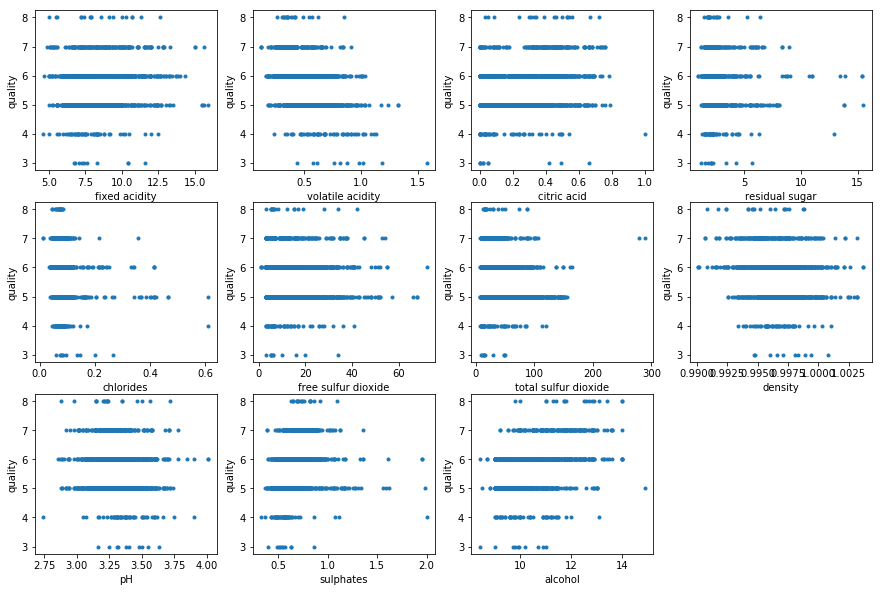

In [10]:
plot_xsections(wine_df.drop('quality', axis=1).values, 
               wine_df.iloc[:, -1], colnames=wine_df.columns)

### Pairwise plots

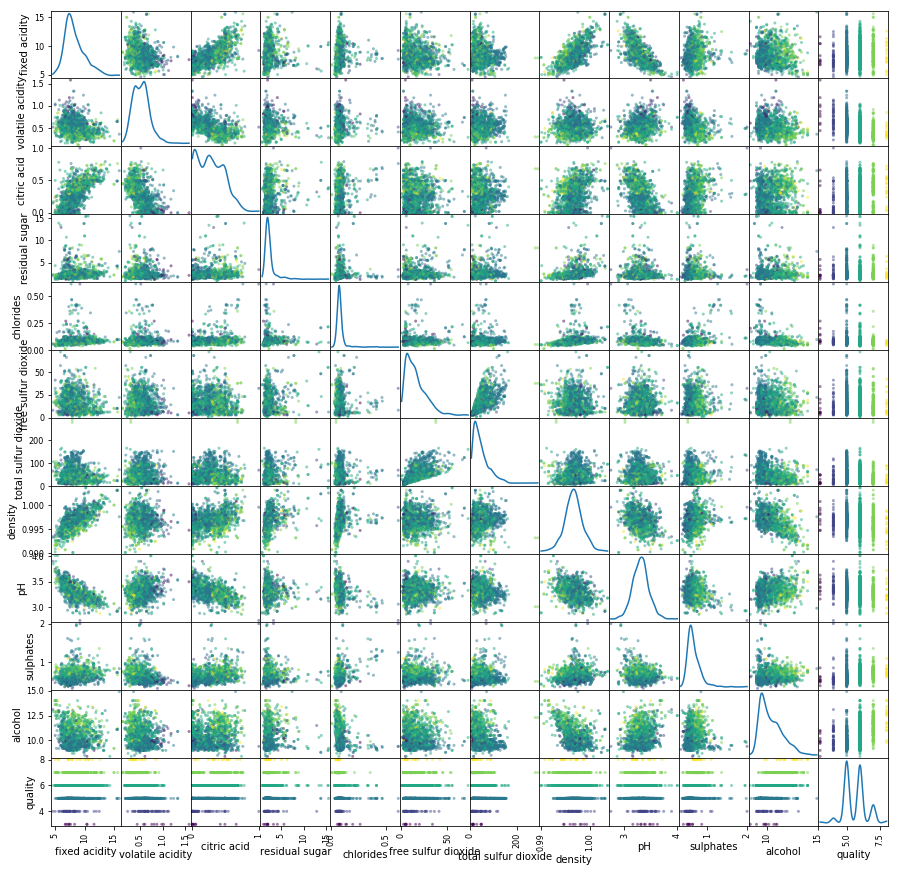

In [11]:
scatter_mat = pd.plotting.scatter_matrix(wine_df, diagonal='kde', figsize=(15, 15), c=wine_df['quality']);

### Histograms

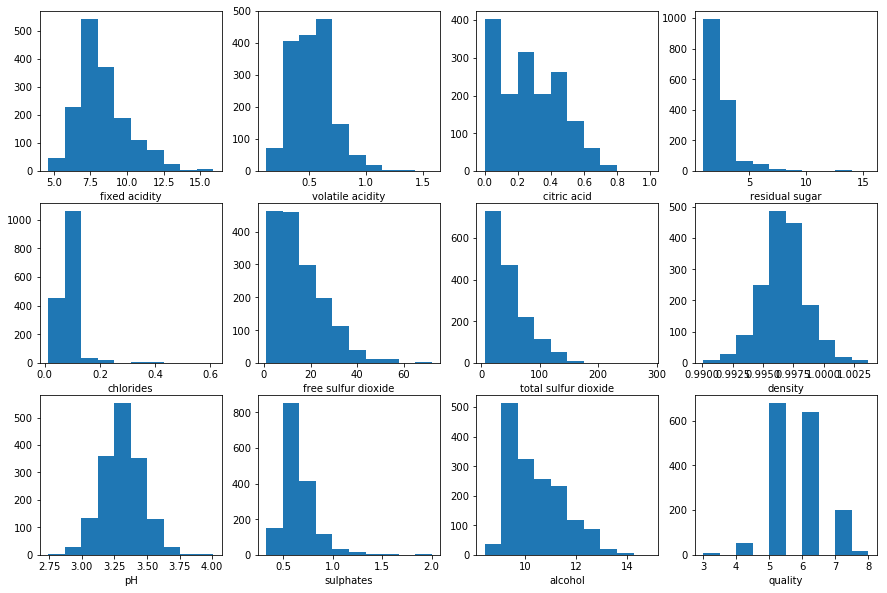

In [12]:
hist_groups(wine_df.values, xlabs=wine_columns)

In [13]:
wine_df.groupby('quality').agg('mean')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,8.360000,0.884500,0.171000,2.635000,0.122500,11.000000,24.900000,0.997464,3.398000,0.570000,9.955000
4,7.779245,0.693962,0.174151,2.694340,0.090679,12.264151,36.245283,0.996542,3.381509,0.596415,10.265094
5,8.167254,0.577041,0.243686,2.528855,0.092736,16.983847,56.513950,0.997104,3.304949,0.620969,9.899706
6,8.347179,0.497484,0.273824,2.477194,0.084956,15.711599,40.869906,0.996615,3.318072,0.675329,10.629519
7,8.872362,0.403920,0.375176,2.720603,0.076588,14.045226,35.020101,0.996104,3.290754,0.741256,11.465913
8,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444


In [14]:
doLogTransform = False
if doLogTransform:
    wine_df = assignTransformedColumn(wine_df, ['fixed acidity', 'volatile acidity', 'chlorides', 'residual sugar',
                                                'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'])
    hist_groups(wine_df.values, xlabs=wine_df.columns, figsize=(15,19))
    wine_df.head()

## Breaking up data

In [15]:
y_full = wine_df['quality'].values
y_full[:5]

array([5, 5, 5, 6, 5])

In [16]:
x_full = wine_df.drop('quality', axis=1)
wine_columns = x_full.columns.tolist() + ['quality']
x_full = x_full.values
ncol = x_full.shape[1]
x_full[:3, :]

array([[  7.40000000e+00,   7.00000000e-01,   0.00000000e+00,
          1.90000000e+00,   7.60000000e-02,   1.10000000e+01,
          3.40000000e+01,   9.97800000e-01,   3.51000000e+00,
          5.60000000e-01,   9.40000000e+00],
       [  7.80000000e+00,   8.80000000e-01,   0.00000000e+00,
          2.60000000e+00,   9.80000000e-02,   2.50000000e+01,
          6.70000000e+01,   9.96800000e-01,   3.20000000e+00,
          6.80000000e-01,   9.80000000e+00],
       [  7.80000000e+00,   7.60000000e-01,   4.00000000e-02,
          2.30000000e+00,   9.20000000e-02,   1.50000000e+01,
          5.40000000e+01,   9.97000000e-01,   3.26000000e+00,
          6.50000000e-01,   9.80000000e+00]])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full)

In [18]:
print([arr.shape for arr in (x_train, x_test, y_train, y_test)])

[(1199, 11), (400, 11), (1199,), (400,)]


## Scale data

In [19]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

In [20]:
xrsc_train = robust_scaler.fit_transform(x_train)
xrsc_test = robust_scaler.transform(x_test)

xssc_train = standard_scaler.fit_transform(x_train)
xssc_test = standard_scaler.transform(x_test)

In [21]:
ymean = y_train.mean()
ystd = y_train.std()

ysc_train = (y_train - ymean)/ystd
ysc_test = (y_test - ymean)/ystd

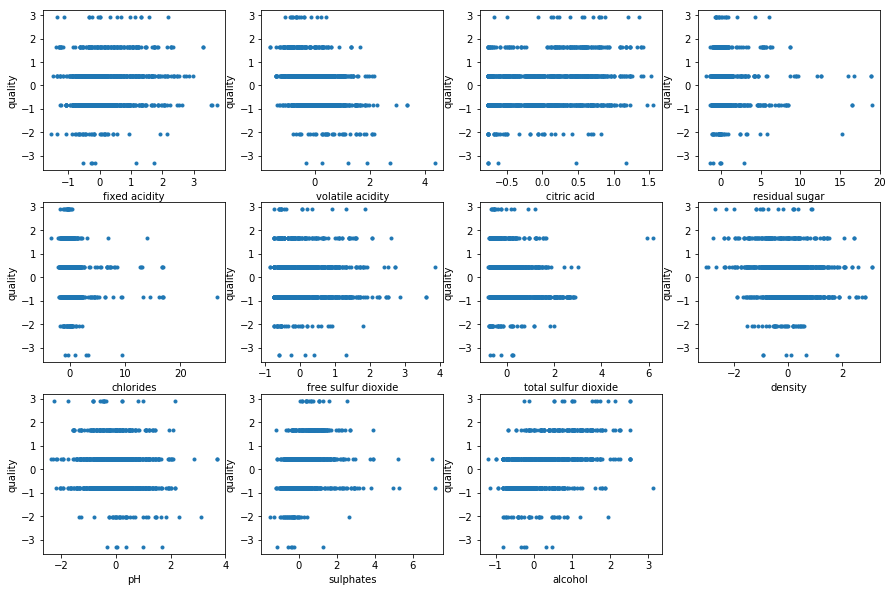

In [22]:
plot_xsections(xrsc_train, ysc_train, colnames=wine_df.columns)

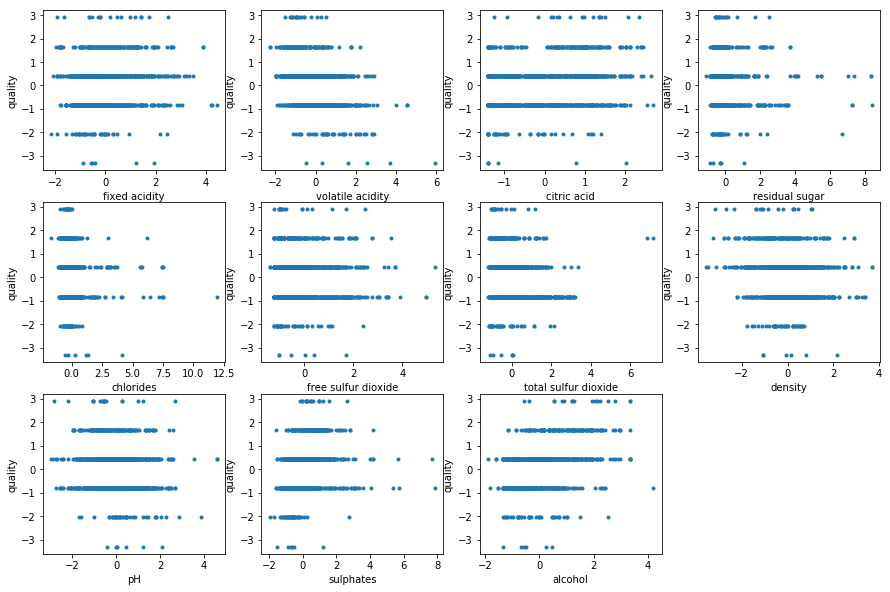

In [23]:
plot_xsections(xssc_train, ysc_train, colnames=wine_df.columns)

# Making some regression happen

## Linear regression

In [24]:
lr_robust = LinearRegression()
lr_standard = LinearRegression()

In [25]:
lr_robust.fit(xrsc_train, ysc_train)
lr_standard.fit(xssc_train, ysc_train)

yrsc_pred = lr_robust.predict(xrsc_test)
yssc_pred = lr_standard.predict(xssc_test)

In [26]:
print('Robust-scaled results:')
score_result(ysc_test, yrsc_pred)
print('\nStandard-scaled results:')
score_result(ysc_test, yssc_pred)

Robust-scaled results:
mean-squared error = 0.6494113940913409
explained variance score = 0.35479396572432
r2_score = 0.3454098301562051

Standard-scaled results:
mean-squared error = 0.6494113940913409
explained variance score = 0.35479396572431987
r2_score = 0.3454098301562051


## LassoCV

In [27]:
las_robust = LassoCV()
las_robust.fit(xrsc_train, ysc_train)

las_standard = LassoCV()
las_standard.fit(xssc_train, ysc_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [28]:
print('LassoCV robust:')
cv_result(las_robust, xrsc_test, ysc_test)

print('\nLassoCV standard:')
cv_result(las_standard, xssc_test, ysc_test)

LassoCV robust:
alpha* = 0.0038445755874472647
coef = [ 0.02152406 -0.30596763 -0.07309189  0.00651256 -0.03434663  0.08880559
 -0.1811772  -0.01481162 -0.13466273  0.21564831  0.52531584]
mean-squared error = 0.6458440870925987
explained variance score = 0.35847977019000854
r2_score = 0.34900558488954936

LassoCV standard:
alpha* = 0.005393694949195197
coef = [ 0.01062082 -0.22764142 -0.04618614  0.00593685 -0.06962865  0.06188059
 -0.14716518 -0.         -0.11135337  0.18582839  0.38348156]
mean-squared error = 0.6471317288397739
explained variance score = 0.3573398199226968
r2_score = 0.3477076747548483


## ElasticNetCV

In [29]:
enetCV_robust = ElasticNetCV()
enetCV_standard = ElasticNetCV()

enetCV_robust.fit(xrsc_train, ysc_train)
enetCV_standard.fit(xssc_train, ysc_train)

print('Elastic Net Robust:')
print('l1 ratio = {}'.format(enetCV_robust.l1_ratio_))
cv_result(enetCV_robust, xrsc_test, ysc_test)

print('\nElastic Net Standard:')
print('l1 ratio = {}'.format(enetCV_standard.l1_ratio_))
cv_result(enetCV_standard, xssc_test, ysc_test)

Elastic Net Robust:
l1 ratio = 0.5
alpha* = 0.006236907580559701
coef = [ 0.03735793 -0.30556898 -0.07739171  0.00856121 -0.03436282  0.08994682
 -0.18201158 -0.02955639 -0.12869189  0.21786161  0.51435096]
mean-squared error = 0.6459917494690223
explained variance score = 0.3583422363331824
r2_score = 0.34885674496936603

Elastic Net Standard:
l1 ratio = 0.5
alpha* = 0.009382321604974198
coef = [ 0.02026463 -0.22709394 -0.04735926  0.00983402 -0.06990504  0.06221773
 -0.14755535 -0.00967365 -0.10727547  0.18719848  0.37717939]
mean-squared error = 0.647036533334501
explained variance score = 0.3574356904457887
r2_score = 0.3478036294032145


### Visual comparison of the coefficient sizes

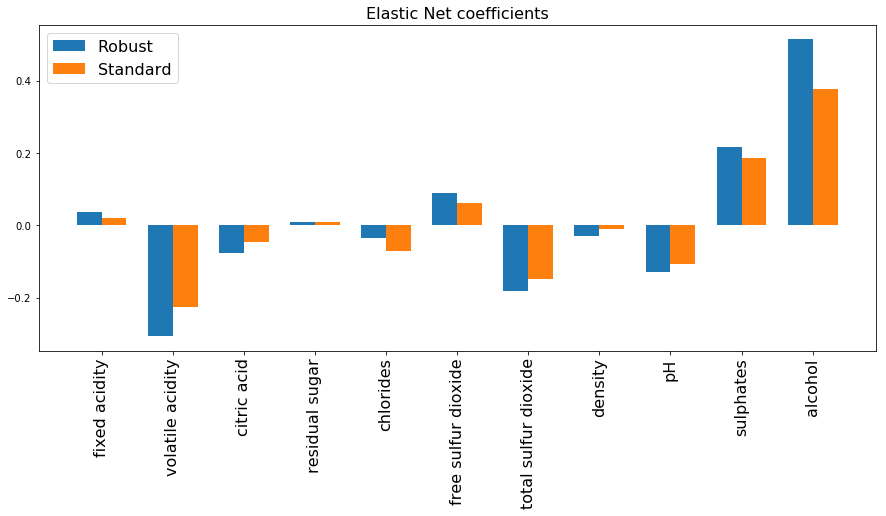

In [30]:
width = .35
left = np.fromiter(range(ncol), dtype=float)

plt.figure(figsize=(15,6))
plt.bar(left-width/2, enetCV_robust.coef_, width, label='Robust')
plt.bar(left + width/2, enetCV_standard.coef_, width, label='Standard')
plt.xticks(range(ncol), wine_columns[:-1], 
           rotation=90, size=16);
plt.legend(fontsize=16);
plt.title('Elastic Net coefficients', size=16);

### Plotting the two most important features from ElasticNetCV

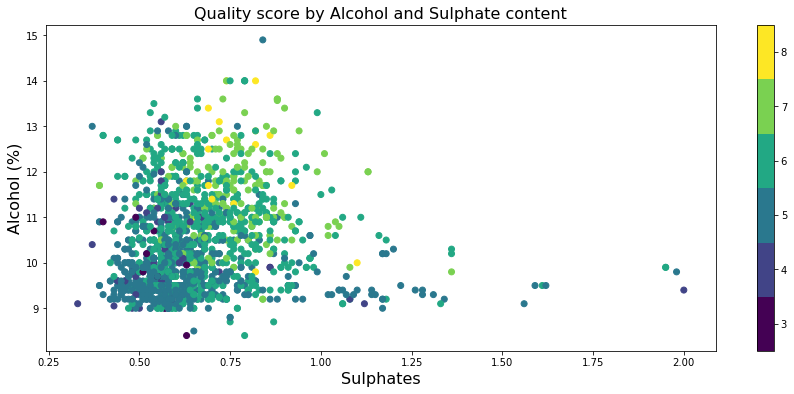

In [31]:
q_max, q_min = wine_df['quality'].agg(['max','min'])

discrete_cb = plt.cm.get_cmap('viridis', q_max-q_min+1)
discrete_colors = discrete_cb(wine_df['quality'].values)

plt.figure(figsize=(15,6))
plt.scatter(wine_df['sulphates'], wine_df['alcohol'], 
            vmin=q_min-.5, vmax=q_max+.5,
            c=wine_df['quality'].values, cmap=discrete_cb)
plt.title('Quality score by Alcohol and Sulphate content', size=16);
plt.xlabel('Sulphates', size=16)
plt.ylabel('Alcohol (%)', size=16)
plt.colorbar(ticks=np.arange(q_min,q_max+1), alpha=1);

## Randomized CV

In [32]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.kernel_ridge import KernelRidge

In [33]:
parm_dists = {'alpha': stats.expon(scale=.1),
              'gamma': stats.expon(scale=.1)}

kridgeCV = RandomizedSearchCV(KernelRidge(kernel='rbf'), param_distributions=parm_dists, n_iter=100, n_jobs=-1)

In [34]:
kridgeCV.fit(xrsc_train, ysc_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116f09518>, 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116bc9198>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [35]:
kridge_results_df = pd.DataFrame.from_dict(kridgeCV.cv_results_)
kridge_results_df.sort_values('rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
55,0.107181,0.007598,0.388650,0.613440,0.257868,0.0728862,"{'gamma': 0.0728862476381, 'alpha': 0.25786812...",1,0.399358,0.608142,0.388087,0.611625,0.378480,0.620553,0.001226,0.000239,0.008531,0.005227
33,0.097858,0.007331,0.386550,0.555633,0.237882,0.0434274,"{'gamma': 0.0434273702222, 'alpha': 0.23788170...",2,0.399825,0.550450,0.381501,0.558257,0.378304,0.558193,0.004631,0.000053,0.009483,0.003666
75,0.128780,0.007225,0.386479,0.550922,0.249317,0.042555,"{'gamma': 0.0425550201477, 'alpha': 0.24931727...",3,0.399369,0.545802,0.381789,0.553741,0.378257,0.553222,0.012279,0.000293,0.009234,0.003626
88,0.107164,0.007797,0.386178,0.579494,0.182978,0.0472376,"{'gamma': 0.0472375658159, 'alpha': 0.18297820...",4,0.401397,0.574002,0.379791,0.580895,0.377324,0.583586,0.003027,0.000430,0.010815,0.004036
40,0.112163,0.009328,0.385760,0.553894,0.212806,0.0405586,"{'gamma': 0.0405585505698, 'alpha': 0.21280608...",5,0.399818,0.548513,0.380190,0.556963,0.377252,0.556206,0.008897,0.001555,0.010019,0.003817


In [36]:
cv_result(kridgeCV.best_estimator_, xrsc_test, ysc_test)

Model does not have attribute alpha_.
Model does not have attribute coef_.
mean-squared error = 0.6363383269774622
explained variance score = 0.3673232796705017
r2_score = 0.3585871493414141


# Nonlinear embeddings

In [37]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

In [38]:
tsne = TSNE()
isomap = Isomap()

tsne_ = tsne.fit_transform(xssc_train)
isomap_ = isomap.fit_transform(xssc_train)

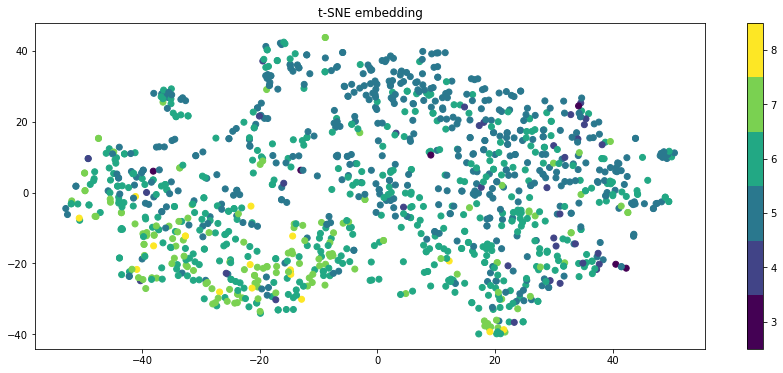

In [39]:
q_max, q_min = (y_train.max(), y_train.min())
discrete_cb = plt.cm.get_cmap('viridis', q_max-q_min+1)

plt.figure(figsize=(15,6))
plt.scatter(tsne_[:,0], tsne_[:,1],
            vmin=q_min-.5, vmax=q_max+.5, 
            c=y_train, cmap=discrete_cb);
plt.title('t-SNE embedding')
plt.colorbar(ticks=np.arange(q_min, q_max+1), alpha=1);

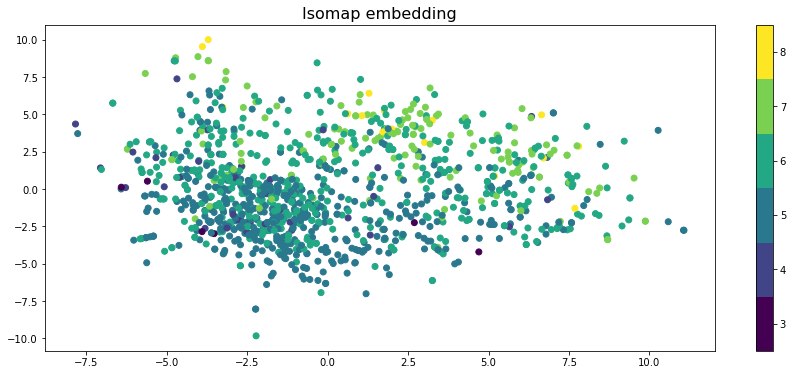

In [40]:
q_max, q_min = (y_train.max(), y_train.min())
discrete_cb = plt.cm.get_cmap('viridis', q_max-q_min+1)

plt.figure(figsize=(15,6))
plt.scatter(isomap_[:,0], isomap_[:,1],
            vmin=q_min-.5, vmax=q_max+.5, 
            c=y_train, cmap=discrete_cb);
plt.title('Isomap embedding',size=16)
plt.colorbar(ticks=np.arange(q_min, q_max+1), alpha=1);